# Task 1
---

In [4]:
import requests
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import json
import time

In [5]:
# create an empty dataframe in order to store the data
df = pd.DataFrame()

Querying the api for each targeted year, extracting the dataset from json response and appending it into a single dataframe.

In [6]:
for year in range(2000, 2021,1):
  
  api_url=f'http://comtrade.un.org/api/get?max=50000&type=S&freq=A&px=EB02&ps={year}&r=all&p=0&rg=all&cc=200' 
  response = requests.get(api_url)

  data_of_each_year = pd.json_normalize(response.json()["dataset"]) # creating a dataframe from the json variable.

  df = pd.concat([df, data_of_each_year]) # joining the data of each year into 1 dataframe.
  time.sleep(1)

## Pre-process and cleaning of the dataset.

In [26]:
# checking the columns in order to identify the columns that are needed.
df.head()

,pfCode,yr,period,periodDesc,aggrLevel,IsLeaf,rgCode,rgDesc,rtCode,rtTitle,...,qtAltCode,qtAltDesc,TradeQuantity,AltQuantity,NetWeight,GrossWeight,TradeValue,CIFValue,FOBValue,estCode
0,EB,2000,2000,2000,0,0,1,Import,8,Albania,...,None,None,None,None,None,None,430300000,None,None,0
1,EB,2000,2000,2000,0,0,2,Export,8,Albania,...,None,None,None,None,None,None,448200000,None,None,0
2,EB,2000,2000,2000,0,0,1,Import,12,Algeria,...,None,None,None,None,None,None,2360000000,None,None,0
3,EB,2000,2000,2000,0,0,2,Export,12,Algeria,...,None,None,None,None,None,None,910000000,None,None,0
4,EB,2000,2000,2000,0,0,1,Import,24,Angola,...,None,None,None,None,None,None,2693419886,None,None,0


The tradevalue column is transformed into only positive values. 

In [27]:
df['TradeValue'] = abs(df['TradeValue'])

In [28]:
# Keep only the relevant columns.
df = df.drop(df.columns.difference(['yr', 'rgDesc', 'rtTitle', 'TradeValue']), axis = 1)
# Rename the columns
df.columns = ["Year", "Trade", "Country", "Trade Value"]
# The dataset is grouped by country and year
df = df.groupby(['Country','Year'], as_index=False).agg({'Trade_Value':'sum'})

In [30]:
df.tail()

,Country,Year,Trade_Value
2774,Zimbabwe,2007,834351954
2775,Zimbabwe,2008,817200000
2776,Zimbabwe,2011,1542600000
2777,Zimbabwe,2014,2316482734
2778,Zimbabwe,2015,1915895930


## It's better to investigate the data we need using sql.

In [31]:
from sqlalchemy import create_engine
engine = create_engine('sqlite://', echo=False)

df.to_sql('t', con=engine)

### As we can see in the query below, the records of each country varies. There are no data for all the years for each country, so the involvement of the countries in international trade is not equal.

In [41]:
engine.execute("SELECT Country, count (*) FROM t GROUP BY Country ORDER BY 2 desc").fetchall()

[('North Macedonia', 17),
 ('Argentina', 16),
 ('Australia', 16),
 ('Austria', 16),
 ('Bahamas', 16),
 ('Bangladesh', 16),
 ('Brazil', 16),
 ('Bulgaria', 16),
 ('Cambodia', 16),
 ('Canada', 16),
 ('Chile', 16),
 ('Colombia', 16),
 ('Costa Rica', 16),
 ('Dominican Rep.', 16),
 ('El Salvador', 16),
 ('Fiji', 16),
 ('Georgia', 16),
 ('India', 16),
 ('Indonesia', 16),
 ('Iraq', 16),
 ('Israel', 16),
 ('Japan', 16),
 ('Jordan', 16),
 ('Kazakhstan', 16),
 ('Kuwait', 16),
 ("Lao People's Dem. Rep.", 16),
 ('Malawi', 16),
 ('Malaysia', 16),
 ('Malta', 16),
 ('Mexico', 16),
 ('Mongolia', 16),
 ('Montenegro', 16),
 ('Morocco', 16),
 ('Mozambique', 16),
 ('Myanmar', 16),
 ('Namibia', 16),
 ('Nepal', 16),
 ('Netherlands', 16),
 ('New Zealand', 16),
 ('Nicaragua', 16),
 ('Oman', 16),
 ('Panama', 16),
 ('Poland', 16),
 ('Portugal', 16),
 ('Romania', 16),
 ('Serbia', 16),
 ('Slovakia', 16),
 ('Slovenia', 16),
 ('Spain', 16),
 ('Sweden', 16),
 ('Switzerland', 16),
 ('Turkey', 16),
 ('United Kingdom', 

In [59]:
# Excluding countries: 
# Eritrea because it has only one data point (records for 1 year) and EU because it is not a country but a union.
df = df.drop(df.index[df['Country'] == "EU"])
df = df.drop(df.index[df['Country'] == "Eritrea"])

### Since the recorded trade years of each country are different, we use the average trade value of each country in order to correctly identify the most and least countries in trading.

In [63]:
df.to_sql('t', con=engine, if_exists = 'replace')
average_trade_value_countries = engine.execute("SELECT Country, avg(Trade_Value)/1000000 FROM t GROUP BY Country ORDER BY 2 desc").fetchall()
average_trade_value_countries_df = pd.DataFrame(average_trade_value_countries, columns=['Countries', 'Average trade value (In millions)'])

10 most involved countries in international trades.

In [64]:
top_countries_in_trading = average_trade_value_countries_df.nlargest(10,'Average trade value (In millions)')

10 least involved countries in international trades.

In [65]:
bottom_countries_in_trading = average_trade_value_countries_df.nsmallest(10,'Average trade value (In millions)')

## Visualisation of 10 most involved countries in international trade.

In [100]:
def display_trending(x_axis, y_axis, title, rotation=0,figsize=(10,10), kind='bar'):
  fig, ax = plt.subplots(figsize = figsize)
  if kind == 'bar':
    ax.bar(x_axis, y_axis)
  else:
    ax.plot(x_axis, y_axis, linewidth=2.0)
  plt.title(title)
  plt.xlabel(x_axis.name)
  plt.ylabel(y_axis.name)
  plt.xticks(rotation = rotation)
  plt.show()
  plt.clf()
  plt.cla()
  plt.close()



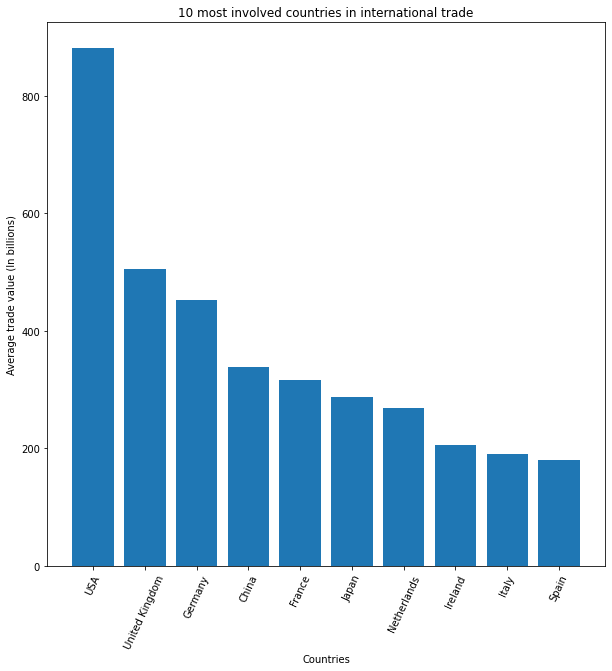

In [102]:
#convert the dollars into billions
top_countries_in_trading['Average trade value (In billions)'] = top_countries_in_trading['Average trade value (In millions)'].astype(int)/1000
display_trendings ([top_countries_in_trading['Countries']], [top_countries_in_trading['Average trade value (In billions)']],
                  "10 most involved countries in international trade", 65)

## Visualisation of 10 least involved countries in international trade.

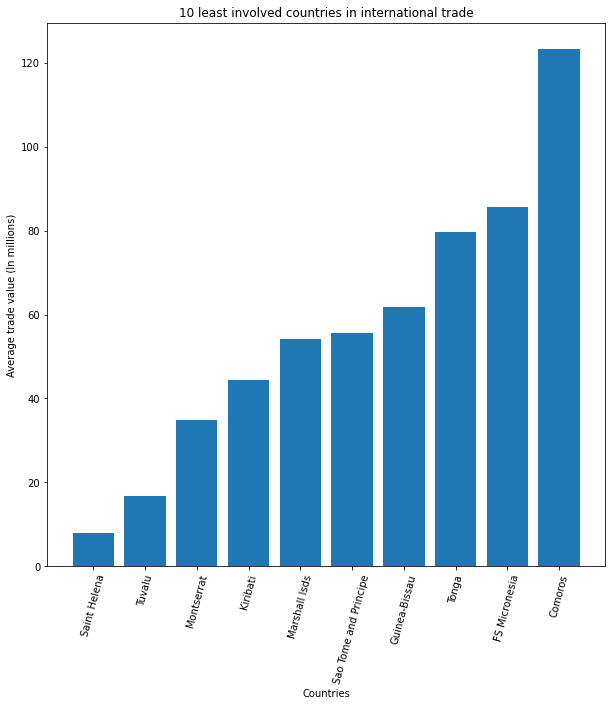

In [93]:
display_trending (bottom_countries_in_trading['Countries'], bottom_countries_in_trading['Average trade value (In millions)'],
                  "10 least involved countries in international trade", 75)

### Development of the most involved countries in international trade.

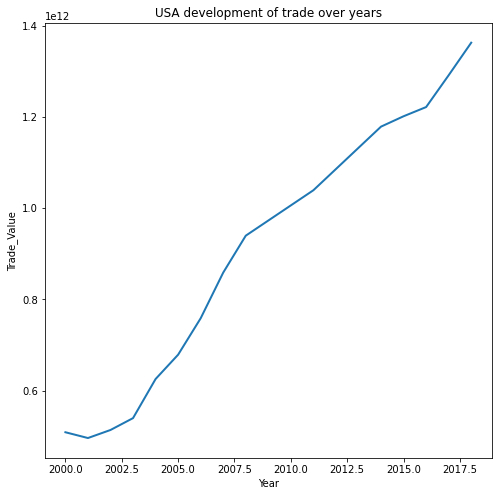

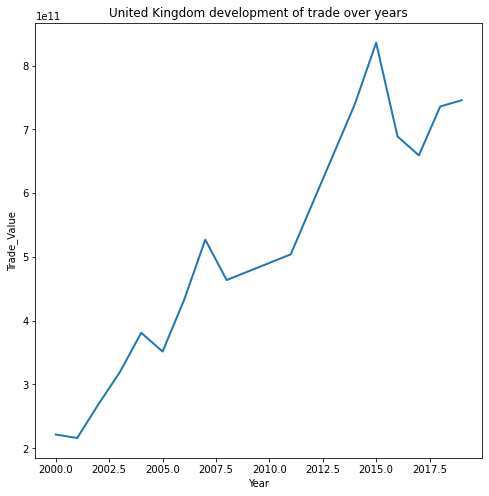

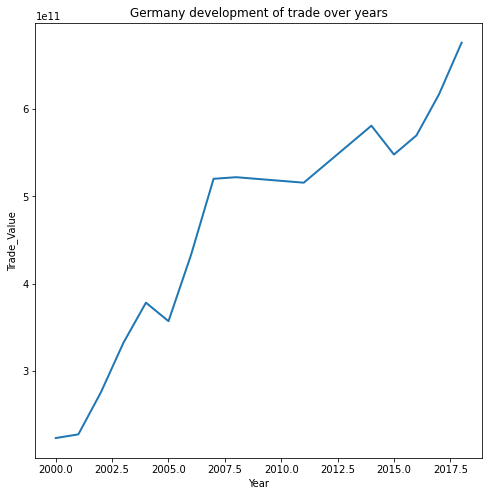

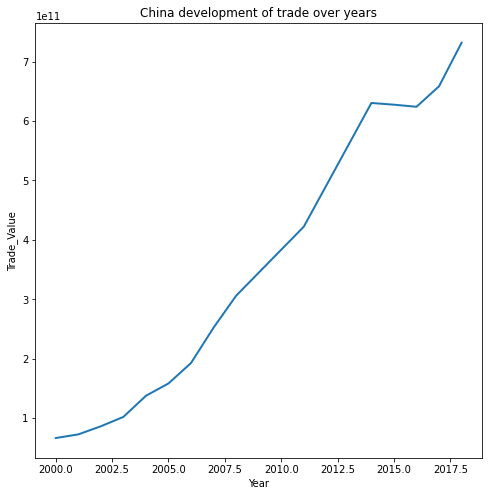

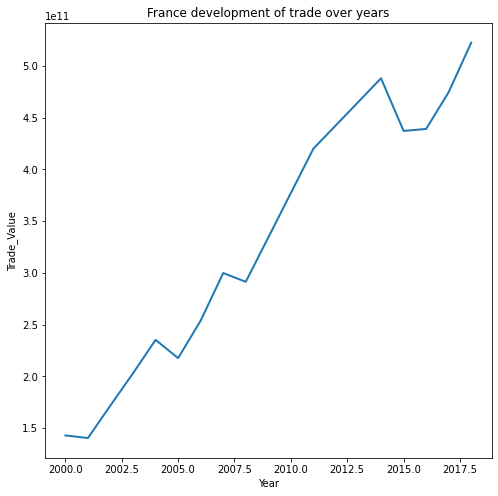

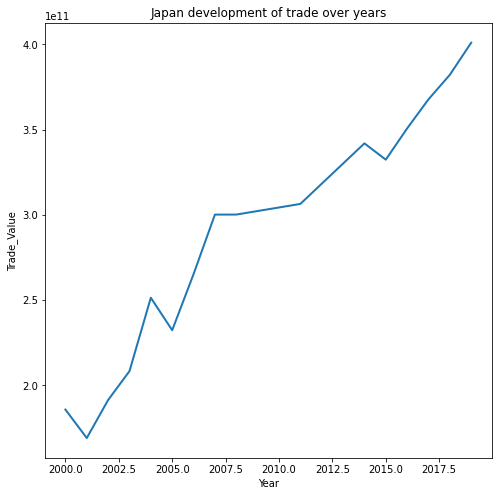

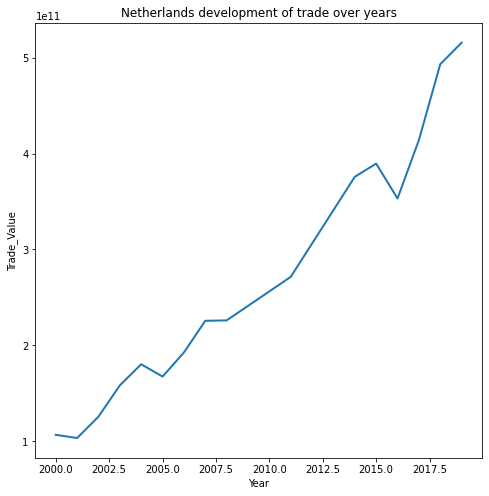

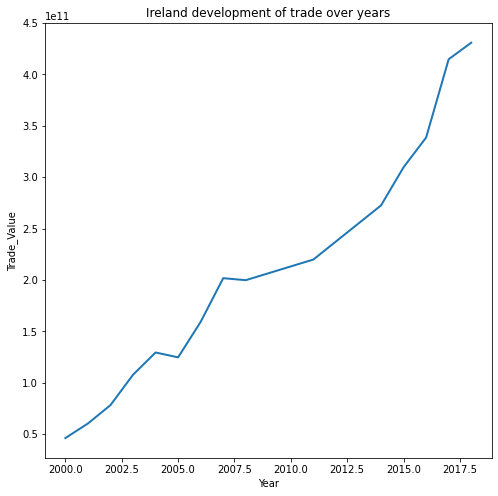

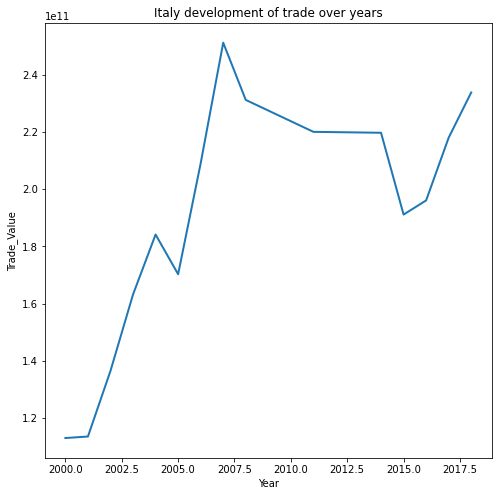

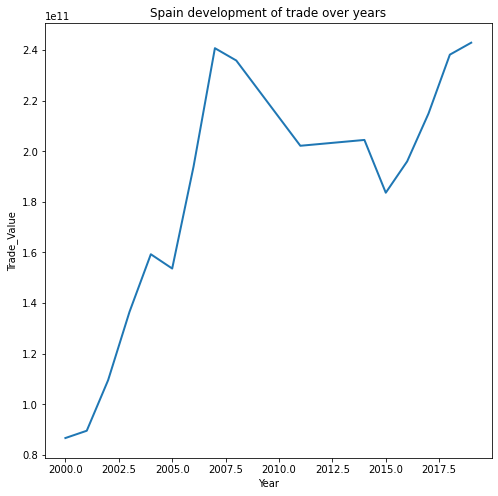

In [95]:
for country in list(top_countries_in_trading['Countries']):
  # filter data using Country
  development_of_country = df[df.Country == country]

  display_trending (development_of_country['Year'], development_of_country['Trade_Value'], f"{country} development of trade over years",kind ='line')
  

In [114]:
def display_multi_trendings(x_axis, y_axis, labels,  title, x_range, rotation=45,figsize=(10,10), kind='line'):
  fig, ax = plt.subplots(figsize = figsize)
  if kind == 'bar':
    for i in range(len(x_axis)):
      ax.bar(x_axis[i], y_axis[i], label = labels[i])
  else:
    for i in range(len(x_axis)):
      ax.plot(x_axis[i], y_axis[i], label= labels[i], linewidth=2.0)
  plt.title(title)
  plt.xlabel(x_axis[0].name)
  plt.ylabel(y_axis[0].name)
  plt.legend()  
  plt.xticks(x_range, rotation = rotation)
  plt.show()
  plt.clf()
  plt.cla()
  plt.close()

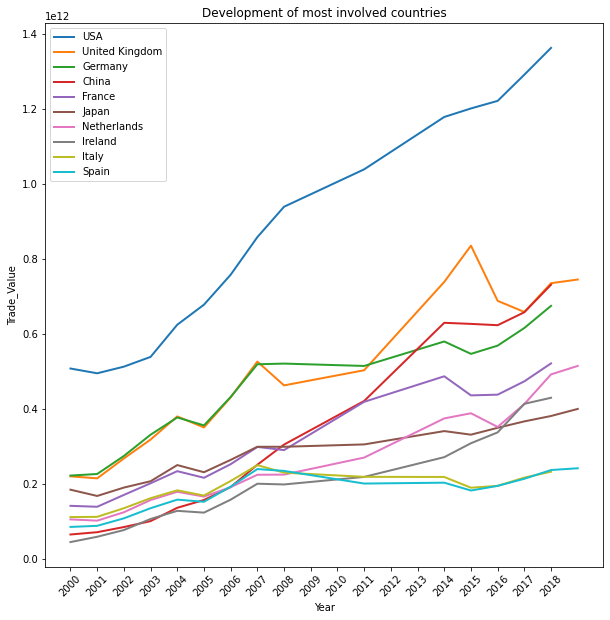

In [115]:
x=[]
y=[]
labels=[]
for country in list(top_countries_in_trading['Countries']):
  # filter data using Country
  development_of_country = df[df.Country == country]
  x.append(development_of_country.Year)
  y.append(development_of_country.Trade_Value)
  labels.append(country)
display_multi_trendings(x,y,labels,"Development of most involved countries", range(min(development_of_country.Year),max(development_of_country.Year)))

### Development of the least involved countries in international trade.

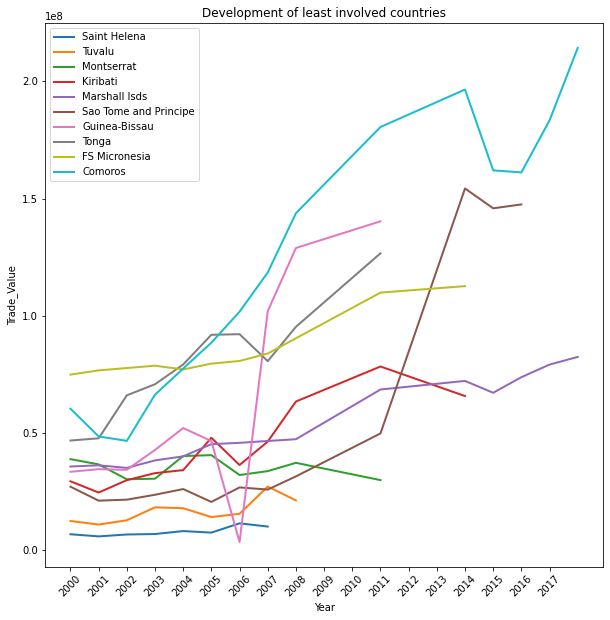

In [116]:
x=[]
y=[]
labels=[]
for country in list(bottom_countries_in_trading['Countries']):
  # filter data using Country
  development_of_country = df[df.Country == country]
  x.append(development_of_country.Year)
  y.append(development_of_country.Trade_Value)
  labels.append(country)
display_multi_trendings(x,y,labels,"Development of least involved countries", range(min(development_of_country.Year),max(development_of_country.Year)))
